**PHASE 3: MODELING - Final Clustering with Selected K**

Purpose: Train final K-Means model with optimal k and assign all papers to clusters  
Input: svd_reduced_{SVD_VARIANT}.pkl, selected k value  
Output: cluster_labels_{SVD_VARIANT}.pkl, cluster_centers, model, metrics  
Algorithm: MiniBatchKMeans with selected k  
ML Involved: ✓ YES - Final unsupervised clustering model  
Runtime: ~30-45 minutes per variant  

Configuration: Set SVD_VARIANT and OPTIMAL_K at top of notebook
- Run cells 1-10 for first variant
- STOP at markdown, change config, rerun cells 1-10 for second variant  
- Then run cells 11-13 for comparison

In [1]:
# imports

import pandas as pd
import numpy as np
import os
import sys
import joblib
import time
from datetime import datetime
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# add project root to path
sys.path.append('..')
from config import CLUSTERING_BATCH_SIZE, RANDOM_STATE

print("✓ All imports loaded")

✓ All imports loaded


In [10]:
# configuration, set these for each path

SVD_VARIANT = "500d"  # options: "300d" or "500d"
OPTIMAL_K = 50      # set based on Notebook 07 results

In [11]:
#confirm setup 

print(f"RUNNING FINAL CLUSTERING FOR SVD-{SVD_VARIANT.upper()}")

# check if k is set
if OPTIMAL_K is None:
    print("⚠ WARNING: OPTIMAL_K not set!")
    print("Review Notebook 07 results and set OPTIMAL_K above")
    raise ValueError("Must set OPTIMAL_K before running")

print(f"Configuration:")
print(f"  SVD variant: {SVD_VARIANT}")
print(f"  Selected k: {OPTIMAL_K}")
print()


RUNNING FINAL CLUSTERING FOR SVD-500D
Configuration:
  SVD variant: 500d
  Selected k: 50



In [12]:
# load necessary data

# load SVD-reduced feature matrix
print(f"\nLoading SVD-reduced data for {SVD_VARIANT}...")
X_reduced = joblib.load(f'data/processed/svd_reduced_{SVD_VARIANT}.pkl')

print(f"✓ Loaded reduced matrix")
print(f"  Shape: {X_reduced.shape}")
print(f"  Papers: {X_reduced.shape[0]:,}")
print(f"  Features: {X_reduced.shape[1]}")
print(f"  Memory: {X_reduced.nbytes / 1024**3:.2f} GB")

# load paper IDs
df_ids = pd.read_pickle('data/processed/tfidf_paper_ids.pkl')
print(f"✓ Loaded paper IDs: {len(df_ids):,}")

# verify alignment
assert len(df_ids) == X_reduced.shape[0], "Mismatch between IDs and features!"
print("✓ ID-feature alignment verified")


Loading SVD-reduced data for 500d...
✓ Loaded reduced matrix
  Shape: (2384622, 500)
  Papers: 2,384,622
  Features: 500
  Memory: 4.44 GB
✓ Loaded paper IDs: 2,384,622
✓ ID-feature alignment verified


In [13]:
# train final MiniBatch K-Means with selected k

print(f"TRAINING FINAL K-MEANS MODEL: k={OPTIMAL_K}")

print(f"Model configuration:")
print(f"  n_clusters: {OPTIMAL_K}")
print(f"  batch_size: {CLUSTERING_BATCH_SIZE}")
print(f"  max_iter: 300")
print(f"  n_init: 10")
print(f"  random_state: {RANDOM_STATE}")
print()

start_time = time.time()

# initialize model with more iterations and inits for final model
kmeans = MiniBatchKMeans(
    n_clusters=OPTIMAL_K,
    batch_size=CLUSTERING_BATCH_SIZE,
    random_state=RANDOM_STATE,
    max_iter=300,        # more iterations for final model
    n_init=10,           # more initializations for stability
    verbose=1,           # show progress
    reassignment_ratio=0.01
)

print("Fitting K-Means model...")

# fit model
fit_start = time.time()
kmeans.fit(X_reduced)
fit_time = time.time() - fit_start

print(f"\n✓ Model fitting complete!")
print(f"  Fit time: {fit_time/60:.1f} minutes")

# predict cluster labels
print(f"\nAssigning cluster labels to all papers...")
predict_start = time.time()
cluster_labels = kmeans.predict(X_reduced)
predict_time = time.time() - predict_start

print(f"✓ Cluster assignment complete!")
print(f"  Prediction time: {predict_time/60:.1f} minutes")

total_time = time.time() - start_time
print(f"\nTotal clustering time: {total_time/60:.1f} minutes")

TRAINING FINAL K-MEANS MODEL: k=50
Model configuration:
  n_clusters: 50
  batch_size: 1024
  max_iter: 300
  n_init: 10
  random_state: 42

Fitting K-Means model...
Init 1/10 with method k-means++
Inertia for init 1/10: 2895.570068359375
Init 2/10 with method k-means++
Inertia for init 2/10: 2942.0400390625
Init 3/10 with method k-means++
Inertia for init 3/10: 2819.646240234375
Init 4/10 with method k-means++
Inertia for init 4/10: 3010.0537109375
Init 5/10 with method k-means++
Inertia for init 5/10: 2965.5244140625
Init 6/10 with method k-means++
Inertia for init 6/10: 2938.203125
Init 7/10 with method k-means++
Inertia for init 7/10: 2839.5205078125
Init 8/10 with method k-means++
Inertia for init 8/10: 2935.10107421875
Init 9/10 with method k-means++
Inertia for init 9/10: 2903.5703125
Init 10/10 with method k-means++
Inertia for init 10/10: 2865.37646484375
[MiniBatchKMeans] Reassigning 21 cluster centers.
Minibatch step 1/698619: mean batch inertia: 0.9125879406929016
[MiniBatc

In [14]:
# calculate basic cluster statistics
unique_labels, cluster_counts = np.unique(cluster_labels, return_counts=True)

print("CLUSTER STATISTICS")
print(f"Number of clusters: {len(unique_labels)}")
print(f"Total papers: {len(cluster_labels):,}")
print(f"\nCluster size distribution:")

cluster_stats = pd.DataFrame({
    'cluster_id': unique_labels,
    'size': cluster_counts,
    'percentage': cluster_counts / len(cluster_labels) * 100
}).sort_values('size', ascending=False)

print(cluster_stats.to_string(index=False))

print("Size statistics:")
print(f"Largest cluster:  {cluster_counts.max():>8,} papers ({cluster_counts.max()/len(cluster_labels)*100:>5.1f}%)")
print(f"Smallest cluster: {cluster_counts.min():>8,} papers ({cluster_counts.min()/len(cluster_labels)*100:>5.1f}%)")
print(f"Mean size:        {cluster_counts.mean():>8,.0f} papers")
print(f"Median size:      {np.median(cluster_counts):>8,.0f} papers")
print(f"Std deviation:    {cluster_counts.std():>8,.0f} papers")

CLUSTER STATISTICS
Number of clusters: 50
Total papers: 2,384,622

Cluster size distribution:
 cluster_id   size  percentage
         34 274874   11.526942
         45 247437   10.376362
         21 195519    8.199161
         23 175807    7.372531
         11 120447    5.050989
         29 100427    4.211443
         47  94441    3.960418
         12  70254    2.946127
         31  65946    2.765470
         15  65295    2.738170
         33  63704    2.671451
         36  62396    2.616599
         38  55682    2.335045
          1  53956    2.262665
         16  53343    2.236958
          9  48313    2.026023
         44  42454    1.780324
          8  40541    1.700102
          0  40304    1.690163
          2  39568    1.659299
         41  38601    1.618747
         35  29413    1.233445
         43  26956    1.130410
         18  25958    1.088558
         22  23914    1.002842
         40  21173    0.887898
         39  20555    0.861981
         10  20274    0.850198
       

In [15]:
# calculate final clustering quality metrics

print("CALCULATING QUALITY METRICS")

metrics_start = time.time()

# silhouette (sample for speed)
print("Calculating silhouette score...")
sample_size = min(100000, X_reduced.shape[0])
sample_indices = np.random.choice(X_reduced.shape[0], sample_size, replace=False)
silhouette = silhouette_score(
    X_reduced[sample_indices],
    cluster_labels[sample_indices],
    sample_size=10000
)
print(f"  ✓ Silhouette: {silhouette:.4f}")

# davies-bouldin
print("Calculating Davies-Bouldin index...")
davies_bouldin = davies_bouldin_score(X_reduced, cluster_labels)
print(f"  ✓ Davies-Bouldin: {davies_bouldin:.4f}")

# calinski-harabasz
print("Calculating Calinski-Harabasz score...")
calinski_harabasz = calinski_harabasz_score(X_reduced, cluster_labels)
print(f"  ✓ Calinski-Harabasz: {calinski_harabasz:.1f}")

# inertia
inertia = kmeans.inertia_
print(f"  ✓ Inertia: {inertia:.1f}")

metrics_time = time.time() - metrics_start

print(f"\nMetrics calculation time: {metrics_time:.1f} seconds")

# store all metrics
final_metrics = {
    'k': OPTIMAL_K,
    'n_clusters': OPTIMAL_K,
    'n_papers': len(cluster_labels),
    'n_features': X_reduced.shape[1],
    'svd_variant': SVD_VARIANT,
    'silhouette': silhouette,
    'davies_bouldin': davies_bouldin,
    'calinski_harabasz': calinski_harabasz,
    'inertia': inertia,
    'fit_time_seconds': fit_time,
    'predict_time_seconds': predict_time,
    'metrics_time_seconds': metrics_time,
    'total_time_seconds': total_time,
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

print("FINAL MODEL METRICS")
print(f"Silhouette Score:        {silhouette:>10.4f}")
print(f"Davies-Bouldin Index:    {davies_bouldin:>10.4f}")
print(f"Calinski-Harabasz Index: {calinski_harabasz:>10.1f}")
print(f"Inertia:                 {inertia:>10.1f}")

CALCULATING QUALITY METRICS
Calculating silhouette score...
  ✓ Silhouette: 0.0278
Calculating Davies-Bouldin index...
  ✓ Davies-Bouldin: 4.2650
Calculating Calinski-Harabasz score...
  ✓ Calinski-Harabasz: 7443.7
  ✓ Inertia: 1427458.8

Metrics calculation time: 5.2 seconds
FINAL MODEL METRICS
Silhouette Score:            0.0278
Davies-Bouldin Index:        4.2650
Calinski-Harabasz Index:     7443.7
Inertia:                  1427458.8


In [16]:
# save core outputs

# save cluster labels
print("SAVING RESULTS")

labels_path = f'data/processed/cluster_labels_{SVD_VARIANT}.pkl'
labels_df = pd.DataFrame({
    'id': df_ids['id'],
    'cluster_id': cluster_labels
})
labels_df.to_pickle(labels_path)
print(f"✓ Saved cluster labels: {labels_path}")

# save cluster centers
centers_path = f'data/processed/cluster_centers_{SVD_VARIANT}.pkl'
joblib.dump(kmeans.cluster_centers_, centers_path)
print(f"✓ Saved cluster centers: {centers_path}")

# save final model
model_path = f'data/processed/kmeans_model_{SVD_VARIANT}.pkl'
joblib.dump(kmeans, model_path)
print(f"✓ Saved K-Means model: {model_path}")

# save final metrics
metrics_path = f'data/processed/clustering_metrics_{SVD_VARIANT}.pkl'
joblib.dump(final_metrics, metrics_path)
print(f"✓ Saved clustering metrics: {metrics_path}")

# save cluster size distribution
size_dist_path = f'data/processed/cluster_sizes_{SVD_VARIANT}.pkl'
size_distribution = {
    'cluster_ids': cluster_stats['cluster_id'].values,
    'sizes': cluster_stats['size'].values,
    'percentages': cluster_stats['percentage'].values
}
joblib.dump(size_distribution, size_dist_path)
print(f"✓ Saved size distribution: {size_dist_path}")

SAVING RESULTS
✓ Saved cluster labels: data/processed/cluster_labels_500d.pkl
✓ Saved cluster centers: data/processed/cluster_centers_500d.pkl
✓ Saved K-Means model: data/processed/kmeans_model_500d.pkl
✓ Saved clustering metrics: data/processed/clustering_metrics_500d.pkl
✓ Saved size distribution: data/processed/cluster_sizes_500d.pkl


In [17]:
# verify all files for this variant

files_to_check = [
    f'data/processed/cluster_labels_{SVD_VARIANT}.pkl',
    f'data/processed/cluster_centers_{SVD_VARIANT}.pkl',
    f'data/processed/kmeans_model_{SVD_VARIANT}.pkl',
    f'data/processed/clustering_metrics_{SVD_VARIANT}.pkl',
    f'data/processed/cluster_sizes_{SVD_VARIANT}.pkl',
]

print(f"VERIFYING OUTPUTS FOR {SVD_VARIANT.upper()}")

all_good = True
for file_path in files_to_check:
    if os.path.exists(file_path):
        if file_path.endswith('.pkl'):
            size_mb = os.path.getsize(file_path) / 1024**2
            print(f"✓ {file_path}")
            print(f"  Size: {size_mb:.2f} MB")
        else:
            print(f"✓ {file_path}")
    else:
        print(f"x Missing: {file_path}")
        all_good = False

if all_good:
    print(f"\n{'='*60}")
    print(f"✓✓✓ Success! ✓✓✓ - All files created for {SVD_VARIANT.upper()}")
    print(f"{'='*60}")
    print(f"\nClustering complete:")
    print(f"  {OPTIMAL_K} clusters assigned to {len(cluster_labels):,} papers")
    print(f"  Silhouette: {silhouette:.4f}")
    print(f"  Total time: {total_time/60:.1f} minutes")
else:
    print(f"\nx Error - Some files missing for {SVD_VARIANT.upper()}!")

VERIFYING OUTPUTS FOR 500D
✓ data/processed/cluster_labels_500d.pkl
  Size: 38.11 MB
✓ data/processed/cluster_centers_500d.pkl
  Size: 0.10 MB
✓ data/processed/kmeans_model_500d.pkl
  Size: 9.19 MB
✓ data/processed/clustering_metrics_500d.pkl
  Size: 0.00 MB
✓ data/processed/cluster_sizes_500d.pkl
  Size: 0.00 MB

✓✓✓ Success! ✓✓✓ - All files created for 500D

Clustering complete:
  50 clusters assigned to 2,384,622 papers
  Silhouette: 0.0278
  Total time: 0.1 minutes


---
## ⚠️ STOP HERE - CHANGE CONFIGURATION FOR SECOND PATH

**You just completed clustering for:** `SVD_VARIANT = "{SVD_VARIANT}"` with `k = {OPTIMAL_K}`

**Before proceeding to comparison (Cell 10+):**

1. **Change configuration in Cell 1:**
   - Update `SVD_VARIANT` to the OTHER value ("300d" → "500d" or vice versa)
   - Update `OPTIMAL_K` based on Notebook 07 results for that variant

2. **Restart kernel** (to clear variables and avoid confusion)

3. **Run cells 1-8 again** for the second variant

4. **Verify you have BOTH complete:**
   - ✓ `cluster_labels_300d.pkl`
   - ✓ `cluster_labels_500d.pkl`
   - ✓ All associated files for both variants

5. **Then continue to Cell 10** for comparison

**DO NOT proceed until both variants are clustered!**

In [ ]:
# verify both clustering variants have been completed

print("Checking for both clustering results...")
print("="*60)

required_files = {
    '300d': [
        'data/processed/cluster_labels_300d.pkl',
        'data/processed/clustering_metrics_300d.pkl',
    ],
    '500d': [
        'data/processed/cluster_labels_500d.pkl',
        'data/processed/clustering_metrics_500d.pkl',
    ]
}

status = {'300d': True, '500d': True}

for variant, files in required_files.items():
    print(f"\n{variant.upper()} files:")
    for filepath in files:
        if os.path.exists(filepath):
            print(f"  ✓ {filepath}")
        else:
            print(f"  x Missing: {filepath}")
            status[variant] = False

print("\n" + "="*60)

missing_variants = [v for v, complete in status.items() if not complete]

if missing_variants:
    print(f"\nx Error: Incomplete clustering for: {', '.join(missing_variants)}")
    print("\nGo back and run cells 1-8 for missing variant(s)")
    print("Remember to:")
    print("  1. Change SVD_VARIANT in Cell 1")
    print("  2. Set appropriate OPTIMAL_K")
    print("  3. Restart kernel")
    print("  4. Run cells 1-8")
    raise FileNotFoundError("Complete both clustering variants before comparison")
else:
    print("\n✓ Success: Both clustering variants found!")
    print("Proceeding to comparison analysis...")

Checking for both clustering results...

300D files:
  ✓ data/processed/cluster_labels_300d.pkl
  ✓ data/processed/clustering_metrics_300d.pkl
  x Missing: results/clustering_statistics_300d.txt

500D files:
  ✓ data/processed/cluster_labels_500d.pkl
  ✓ data/processed/clustering_metrics_500d.pkl
  x Missing: results/clustering_statistics_500d.txt


x Error: Incomplete clustering for: 300d, 500d

Go back and run cells 1-8 for missing variant(s)
Remember to:
  1. Change SVD_VARIANT in Cell 1
  2. Set appropriate OPTIMAL_K
  3. Restart kernel
  4. Run cells 1-8


FileNotFoundError: Complete both clustering variants before comparison

In [19]:
# load clustering results from both variants
print("\nLoading clustering results for comparison...")
print("-"*60)

# load metrics
metrics_300d = joblib.load('data/processed/clustering_metrics_300d.pkl')
metrics_500d = joblib.load('data/processed/clustering_metrics_500d.pkl')

print(f"✓ Loaded 300d metrics: k={metrics_300d['k']}")
print(f"✓ Loaded 500d metrics: k={metrics_500d['k']}")

# load cluster labels
labels_300d = pd.read_pickle('data/processed/cluster_labels_300d.pkl')
labels_500d = pd.read_pickle('data/processed/cluster_labels_500d.pkl')

print(f"✓ Loaded 300d labels: {len(labels_300d):,} papers")
print(f"✓ Loaded 500d labels: {len(labels_500d):,} papers")

# load size distributions
sizes_300d = joblib.load('data/processed/cluster_sizes_300d.pkl')
sizes_500d = joblib.load('data/processed/cluster_sizes_500d.pkl')

print(f"✓ Loaded size distributions")

print("CONFIGURATION COMPARISON")
print(f"{'Metric':<25} {'SVD-300d':<20} {'SVD-500d'}")
print(f"{'Number of clusters':<25} {metrics_300d['k']:<20} {metrics_500d['k']}")
print(f"{'Feature dimensions':<25} {metrics_300d['n_features']:<20} {metrics_500d['n_features']}")
print(f"{'Papers clustered':<25} {metrics_300d['n_papers']:>9,}{' '*10} {metrics_500d['n_papers']:>9,}")


Loading clustering results for comparison...
------------------------------------------------------------
✓ Loaded 300d metrics: k=50
✓ Loaded 500d metrics: k=50
✓ Loaded 300d labels: 2,384,622 papers
✓ Loaded 500d labels: 2,384,622 papers
✓ Loaded size distributions
CONFIGURATION COMPARISON
Metric                    SVD-300d             SVD-500d
Number of clusters        50                   50
Feature dimensions        300                  500
Papers clustered          2,384,622           2,384,622


In [20]:
# save comparison summary
comparison_path = 'results/clustering_comparison.txt'

with open(comparison_path, 'w') as f:
    f.write("FINAL CLUSTERING COMPARISON: SVD-300D VS SVD-500D\n")
    f.write(f"Analysis date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
    
    f.write("CONFIGURATION\n")
    f.write(f"{'Metric':<30} {'SVD-300d':<25} {'SVD-500d'}\n")
    f.write(f"{'Variance preserved':<30} {'53%':<25} {'71%'}\n")
    f.write(f"{'Feature dimensions':<30} {str(metrics_300d['n_features']):<25} {str(metrics_500d['n_features'])}\n")
    f.write(f"{'Number of clusters (k)':<30} {str(metrics_300d['k']):<25} {str(metrics_500d['k'])}\n")
    f.write(f"{'Papers clustered':<30} {metrics_300d['n_papers']:>9,}{' '*15} {metrics_500d['n_papers']:>9,}\n")
    
    f.write(f"\n")
    f.write("QUALITY METRICS\n")
    f.write(f"{'Metric':<30} {'SVD-300d':<25} {'SVD-500d'}\n")
    f.write(f"{'Silhouette Score':<30} {metrics_300d['silhouette']:<25.4f} {metrics_500d['silhouette']:.4f}\n")
    f.write(f"{'Davies-Bouldin Index':<30} {metrics_300d['davies_bouldin']:<25.4f} {metrics_500d['davies_bouldin']:.4f}\n")
    f.write(f"{'Calinski-Harabasz Score':<30} {metrics_300d['calinski_harabasz']:<25.1f} {metrics_500d['calinski_harabasz']:.1f}\n")
    f.write(f"{'Inertia':<30} {metrics_300d['inertia']:<25.1f} {metrics_500d['inertia']:.1f}\n")
    
    f.write(f"\n")
    f.write("RUNTIME COMPARISON\n")
    f.write(f"{'Stage':<30} {'SVD-300d':<25} {'SVD-500d'}\n")
    
    fit_300 = metrics_300d['fit_time_seconds'] / 60
    fit_500 = metrics_500d['fit_time_seconds'] / 60
    f.write(f"{'Model fitting (minutes)':<30} {fit_300:<25.1f} {fit_500:.1f}\n")
    
    pred_300 = metrics_300d['predict_time_seconds'] / 60
    pred_500 = metrics_500d['predict_time_seconds'] / 60
    f.write(f"{'Label prediction (minutes)':<30} {pred_300:<25.1f} {pred_500:.1f}\n")
    
    total_300 = metrics_300d['total_time_seconds'] / 60
    total_500 = metrics_500d['total_time_seconds'] / 60
    f.write(f"{'Total time (minutes)':<30} {total_300:<25.1f} {total_500:.1f}\n")
    
    time_diff = total_500 - total_300
    time_pct = (total_500 / total_300 - 1) * 100
    f.write(f"{'Time difference':<30} {time_diff:<25.1f} min ({time_pct:+.1f}%)\n")
    
    f.write(f"\n")
    f.write("CLUSTER SIZE STATISTICS\n")
    f.write(f"{'Statistic':<30} {'SVD-300d':<25} {'SVD-500d'}\n")
    
    f.write(f"{'Largest cluster':<30} {sizes_300d['sizes'].max():>9,}{' '*15} {sizes_500d['sizes'].max():>9,}\n")
    f.write(f"{'Smallest cluster':<30} {sizes_300d['sizes'].min():>9,}{' '*15} {sizes_500d['sizes'].min():>9,}\n")
    f.write(f"{'Mean size':<30} {sizes_300d['sizes'].mean():>9,.0f}{' '*15} {sizes_500d['sizes'].mean():>9,.0f}\n")
    f.write(f"{'Median size':<30} {np.median(sizes_300d['sizes']):>9,.0f}{' '*15} {np.median(sizes_500d['sizes']):>9,.0f}\n")
    f.write(f"{'Std deviation':<30} {sizes_300d['sizes'].std():>9,.0f}{' '*15} {sizes_500d['sizes'].std():>9,.0f}\n")

print(f"✓ Saved comparison summary: {comparison_path}")

✓ Saved comparison summary: results/clustering_comparison.txt


✓ Saved comparison figure: results/figures/clustering_final_comparison.png


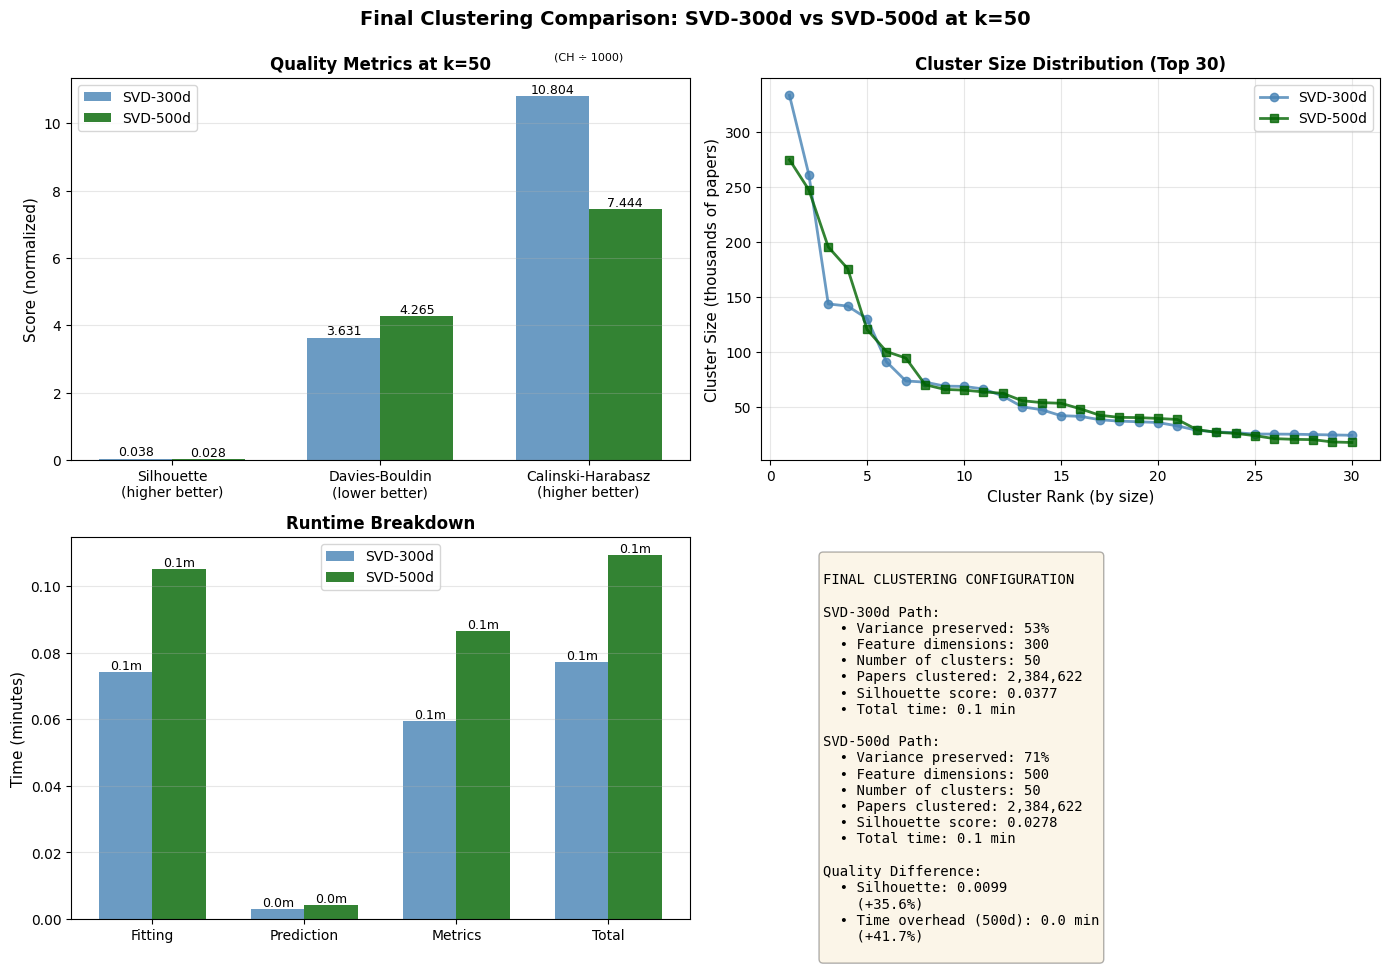

In [22]:
# create visual comparison of final clustering quality

import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# prepare data
metrics_data = {
    '300d': {
        'k': metrics_300d['k'],
        'silhouette': metrics_300d['silhouette'],
        'davies_bouldin': metrics_300d['davies_bouldin'],
        'calinski_harabasz': metrics_300d['calinski_harabasz'],
        'time': metrics_300d['total_time_seconds'] / 60
    },
    '500d': {
        'k': metrics_500d['k'],
        'silhouette': metrics_500d['silhouette'],
        'davies_bouldin': metrics_500d['davies_bouldin'],
        'calinski_harabasz': metrics_500d['calinski_harabasz'],
        'time': metrics_500d['total_time_seconds'] / 60
    }
}

# plot 1: quality metrics comparison (bar chart)

ax1 = axes[0, 0]

metrics_names = ['Silhouette\n(higher better)', 'Davies-Bouldin\n(lower better)', 
                 'Calinski-Harabasz\n(higher better)']
x_pos = np.arange(len(metrics_names))
width = 0.35

# normalize for visualization (different scales)

sil_300 = metrics_data['300d']['silhouette']
sil_500 = metrics_data['500d']['silhouette']
db_300 = metrics_data['300d']['davies_bouldin']
db_500 = metrics_data['500d']['davies_bouldin']
ch_300 = metrics_data['300d']['calinski_harabasz'] / 1000  # scale down for visibility
ch_500 = metrics_data['500d']['calinski_harabasz'] / 1000

values_300d = [sil_300, db_300, ch_300]
values_500d = [sil_500, db_500, ch_500]

bars1 = ax1.bar(x_pos - width/2, values_300d, width, label='SVD-300d', 
                color='steelblue', alpha=0.8)
bars2 = ax1.bar(x_pos + width/2, values_500d, width, label='SVD-500d', 
                color='darkgreen', alpha=0.8)

# add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

ax1.set_xticks(x_pos)
ax1.set_xticklabels(metrics_names, fontsize=10)
ax1.set_ylabel('Score (normalized)', fontsize=11)
ax1.set_title('Quality Metrics at k=50', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')
ax1.axhline(y=0, color='black', linewidth=0.5)

# note about CH scaling
ax1.text(2, max(ch_300, ch_500) * 1.1, '(CH ÷ 1000)', fontsize=8, ha='center')

# plot 2: cluster size distribution comparison

ax2 = axes[0, 1]

sizes_300d_sorted = np.sort(sizes_300d['sizes'])[::-1]
sizes_500d_sorted = np.sort(sizes_500d['sizes'])[::-1]

# show top 30 clusters

n_show = min(30, len(sizes_300d_sorted), len(sizes_500d_sorted))

ax2.plot(range(1, n_show+1), sizes_300d_sorted[:n_show]/1000, 
         'o-', color='steelblue', label='SVD-300d', linewidth=2, markersize=6, alpha=0.8)
ax2.plot(range(1, n_show+1), sizes_500d_sorted[:n_show]/1000, 
         's-', color='darkgreen', label='SVD-500d', linewidth=2, markersize=6, alpha=0.8)

ax2.set_xlabel('Cluster Rank (by size)', fontsize=11)
ax2.set_ylabel('Cluster Size (thousands of papers)', fontsize=11)
ax2.set_title(f'Cluster Size Distribution (Top {n_show})', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# plot 3: runtime breakdown

ax3 = axes[1, 0]

stages = ['Fitting', 'Prediction', 'Metrics', 'Total']
time_300d = [
    metrics_300d['fit_time_seconds']/60,
    metrics_300d['predict_time_seconds']/60,
    metrics_300d['metrics_time_seconds']/60,
    metrics_300d['total_time_seconds']/60
]
time_500d = [
    metrics_500d['fit_time_seconds']/60,
    metrics_500d['predict_time_seconds']/60,
    metrics_500d['metrics_time_seconds']/60,
    metrics_500d['total_time_seconds']/60
]

x_pos = np.arange(len(stages))
bars1 = ax3.bar(x_pos - width/2, time_300d, width, label='SVD-300d', 
                color='steelblue', alpha=0.8)
bars2 = ax3.bar(x_pos + width/2, time_500d, width, label='SVD-500d', 
                color='darkgreen', alpha=0.8)

# add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}m', ha='center', va='bottom', fontsize=9)

ax3.set_xticks(x_pos)
ax3.set_xticklabels(stages, fontsize=10)
ax3.set_ylabel('Time (minutes)', fontsize=11)
ax3.set_title('Runtime Breakdown', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# plot 4: configuration summary (text)

ax4 = axes[1, 1]
ax4.axis('off')

summary_text = f"""
FINAL CLUSTERING CONFIGURATION

SVD-300d Path:
  • Variance preserved: 53%
  • Feature dimensions: {metrics_300d['n_features']}
  • Number of clusters: {metrics_300d['k']}
  • Papers clustered: {metrics_300d['n_papers']:,}
  • Silhouette score: {metrics_300d['silhouette']:.4f}
  • Total time: {metrics_300d['total_time_seconds']/60:.1f} min

SVD-500d Path:
  • Variance preserved: 71%
  • Feature dimensions: {metrics_500d['n_features']}
  • Number of clusters: {metrics_500d['k']}
  • Papers clustered: {metrics_500d['n_papers']:,}
  • Silhouette score: {metrics_500d['silhouette']:.4f}
  • Total time: {metrics_500d['total_time_seconds']/60:.1f} min

Quality Difference:
  • Silhouette: {(metrics_300d['silhouette'] - metrics_500d['silhouette']):.4f}
    ({(metrics_300d['silhouette']/metrics_500d['silhouette'] - 1)*100:+.1f}%)
  • Time overhead (500d): {(metrics_500d['total_time_seconds'] - metrics_300d['total_time_seconds'])/60:.1f} min
    ({(metrics_500d['total_time_seconds']/metrics_300d['total_time_seconds'] - 1)*100:+.1f}%)
"""

ax4.text(0.1, 0.95, summary_text, transform=ax4.transAxes,
         fontsize=10, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.suptitle('Final Clustering Comparison: SVD-300d vs SVD-500d at k=50', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()

# save comparison figure

os.makedirs('results/figures', exist_ok=True)
fig_path = 'results/figures/clustering_final_comparison.png'
plt.savefig(fig_path, dpi=150, bbox_inches='tight')
print(f"✓ Saved comparison figure: {fig_path}")

plt.show()

In [ ]:
# Verify all outputs (individual + comparison)
print("FINAL VERIFICATION - ALL OUTPUTS")

all_files = {
    'SVD-300d individual': [
        'data/processed/cluster_labels_300d.pkl',
        'data/processed/cluster_centers_300d.pkl',
        'data/processed/kmeans_model_300d.pkl',
        'data/processed/clustering_metrics_300d.pkl',
        'data/processed/cluster_sizes_300d.pkl',
    ],
    'SVD-500d individual': [
        'data/processed/cluster_labels_500d.pkl',
        'data/processed/cluster_centers_500d.pkl',
        'data/processed/kmeans_model_500d.pkl',
        'data/processed/clustering_metrics_500d.pkl',
        'data/processed/cluster_sizes_500d.pkl',
    ],
    'Comparison': [
        'results/clustering_comparison.txt',
        'results/figures/clustering_final_comparison.png',
    ]
}

all_good = True

for category, files in all_files.items():
    print(f"\n{category}:")
    print("-"*60)
    for filepath in files:
        if os.path.exists(filepath):
            print(f"  ✓ {filepath}")
        else:
            print(f"  x Missing: {filepath}")
            all_good = False

print("\n" + "="*60)

if all_good:
    print("✓✓✓ Success! ✓✓✓- All clustering files created!")
    print("="*60)
    print(f"\nBoth clustering paths complete:")
    print(f"  SVD-300d: k={metrics_300d['k']}, silhouette={metrics_300d['silhouette']:.4f}")
    print(f"  SVD-500d: k={metrics_500d['k']}, silhouette={metrics_500d['silhouette']:.4f}")
else:
    print("x Error - Some files missing!")
    print("Check which step needs to be rerun")

FINAL VERIFICATION - ALL OUTPUTS

SVD-300d individual:
------------------------------------------------------------
  ✓ data/processed/cluster_labels_300d.pkl
  ✓ data/processed/cluster_centers_300d.pkl
  ✓ data/processed/kmeans_model_300d.pkl
  ✓ data/processed/clustering_metrics_300d.pkl
  ✓ data/processed/cluster_sizes_300d.pkl
  x Missing: results/clustering_statistics_300d.txt

SVD-500d individual:
------------------------------------------------------------
  ✓ data/processed/cluster_labels_500d.pkl
  ✓ data/processed/cluster_centers_500d.pkl
  ✓ data/processed/kmeans_model_500d.pkl
  ✓ data/processed/clustering_metrics_500d.pkl
  ✓ data/processed/cluster_sizes_500d.pkl
  x Missing: results/clustering_statistics_500d.txt

Comparison:
------------------------------------------------------------
  ✓ results/clustering_comparison.txt

x Error - Some files missing!
Check which step needs to be rerun
